# Introduction to Arkouda

Arkouda is a powerful framework designed to bridge the gap between data scientists and high-performance computing (HPC) systems. By providing a Python interface to interact with large-scale data on HPC systems, Arkouda enables users to perform complex computations on massive datasets with ease. This tutorial will guide you through the basics of Arkouda, helping you understand its core features and how to leverage it for scalable data analysis.



### Why use arkouda over pandas or numpy?
Arkouda is designed for distributed computing, allowing it to handle datasets that are too large to fit into the memory of a single machine. Unlike pandas or numpy, which operate on a single node, Arkouda leverages the power of HPC systems to perform computations in parallel, making it ideal for large-scale data analysis tasks.

### How does arkouda work?
Arkouda operates on a client-server model, where the client is a Python program that sends commands to a server written in Chapel, a high-performance parallel programming language. The server executes these commands on distributed data and returns the results to the client. This architecture allows Arkouda to leverage the scalability and performance of HPC systems while providing a user-friendly Python interface.

The client has a reference to the data stored on the server and can therefore operate on it without needing to store the data itself.

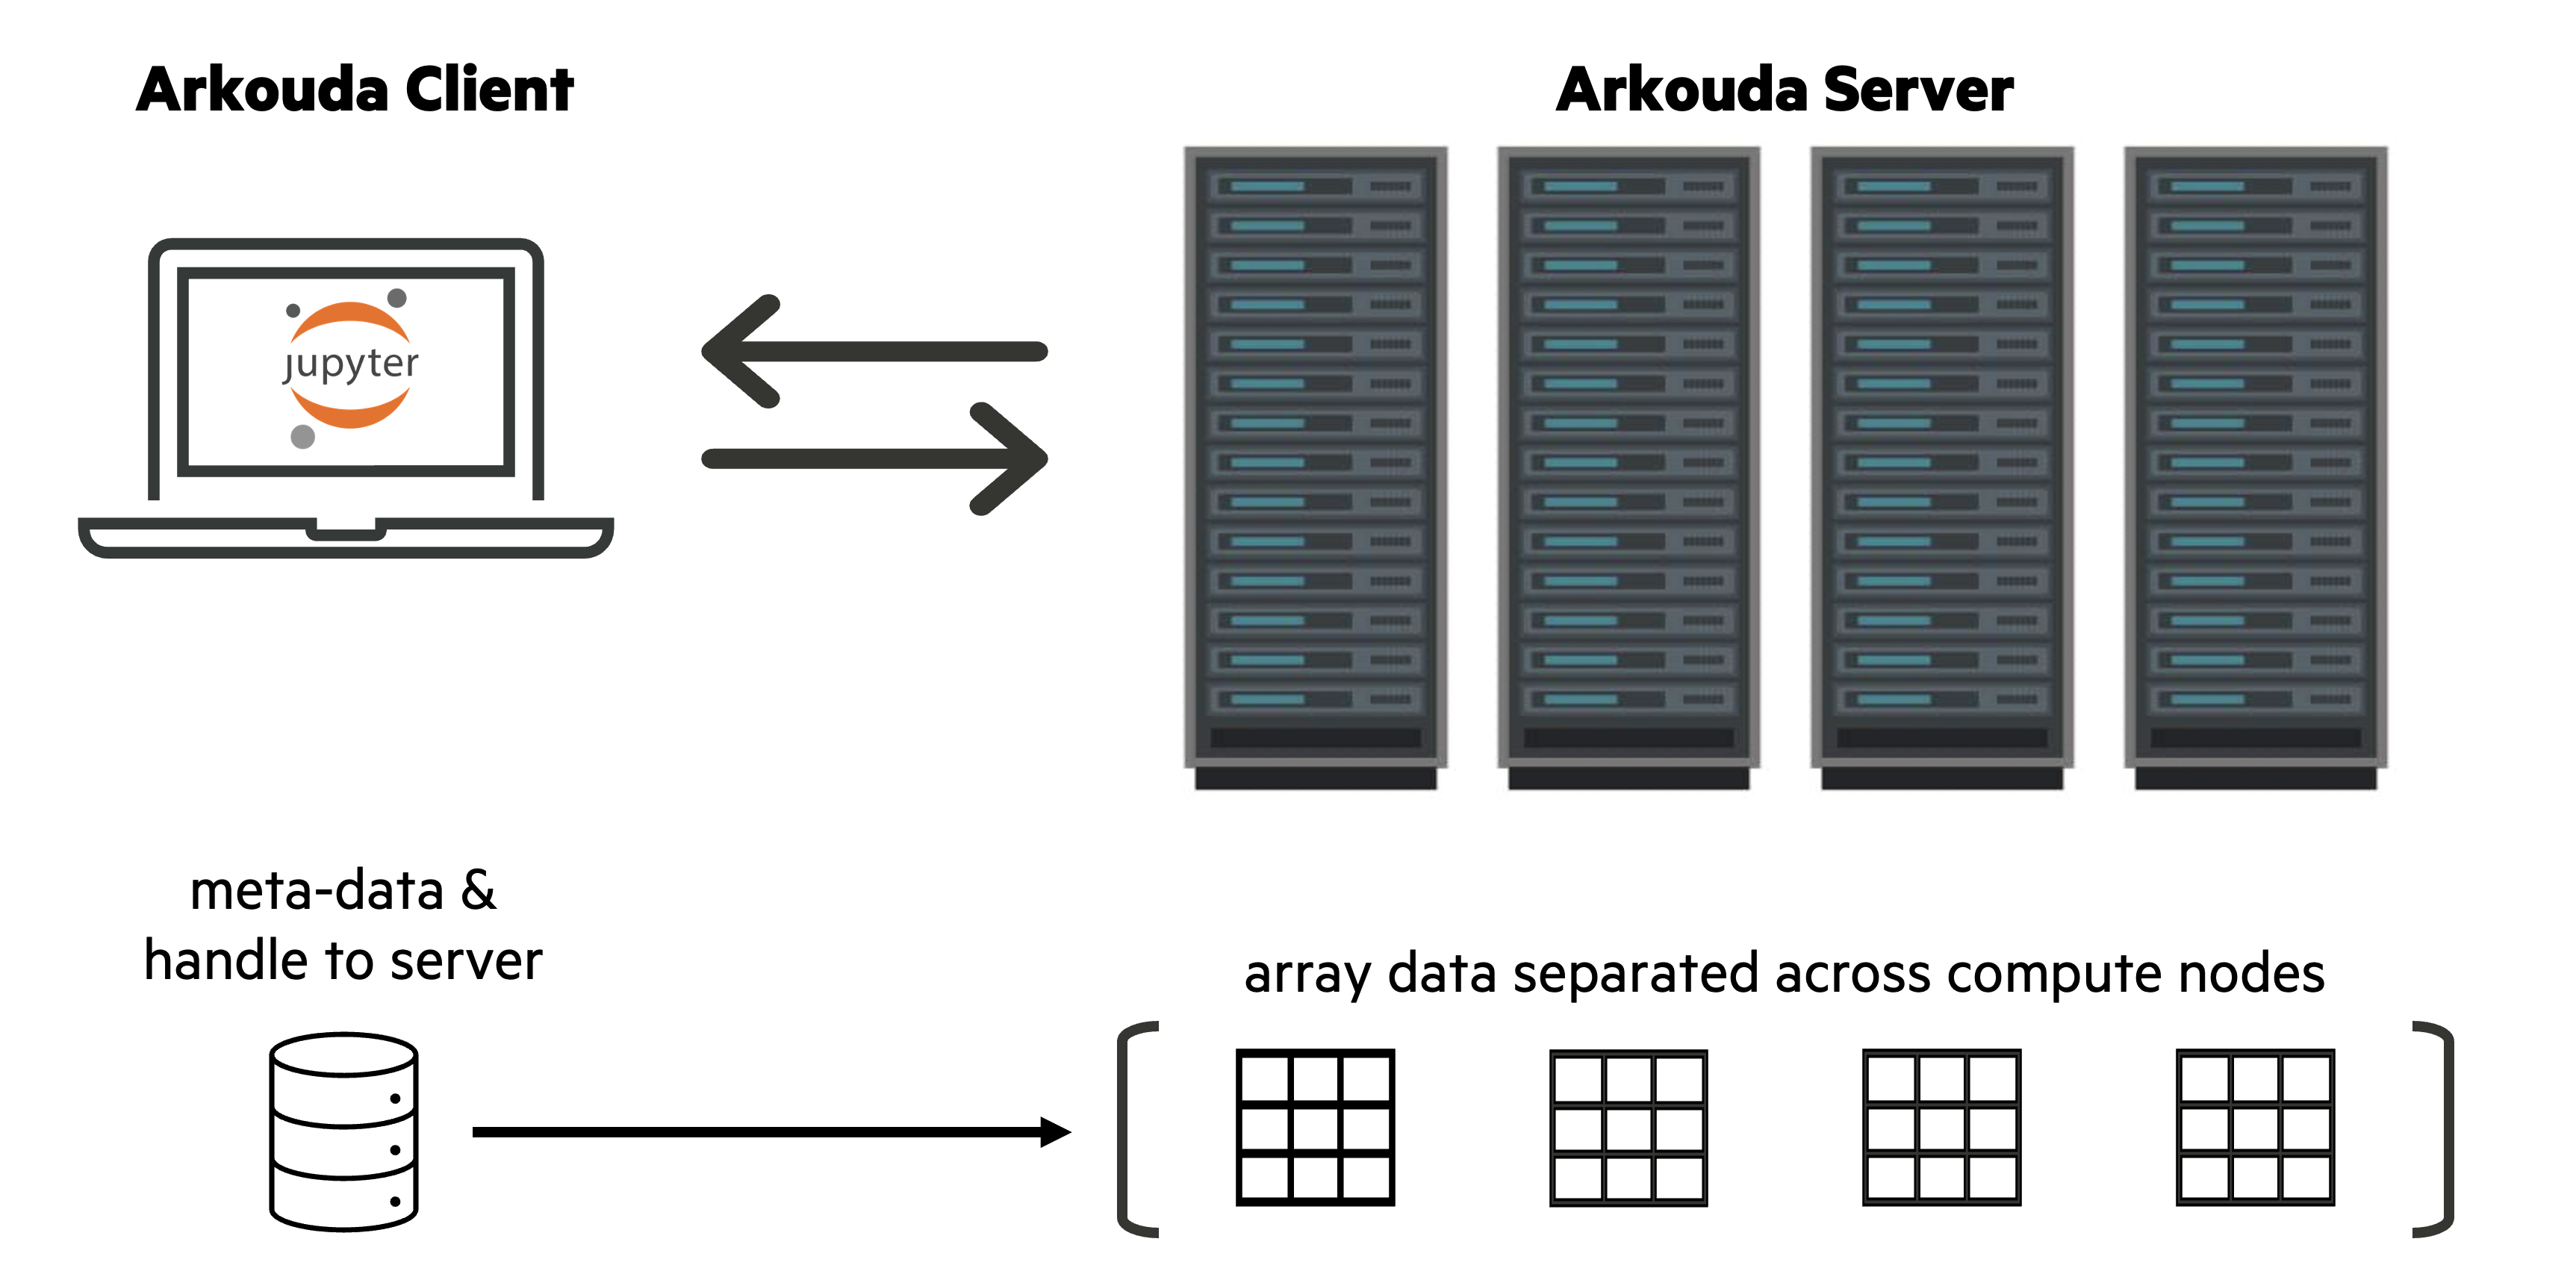

Chapel, the language used to implement the Arkouda server, is designed for productive parallel programming. It simplifies the development of parallel applications by providing high-level abstractions for distributed memory and parallelism. By using Chapel, Arkouda achieves both high performance and scalability, with the ability to rapidly expand its features.

### I don't have an HPC system. Can I run arkouda?
Yes! Arkouda can be run on any machine, such as your laptop, or even a small cluster, vm, or cloud! While it is designed to leverage HPC systems for large-scale computations, you can install and run Arkouda locally to explore its features and develop your workflows before deploying them on an HPC system.


### Arkouda Modules
Arkouda is modular, and therefore new features can be added as new Arkouda modules quickly. Users can pick and choose which of these modules they want to include in their server builds, allowing for a customizable and lightweight setup tailored to specific use cases.
https://github.com/bears-r-us/arkouda



## Learn more about Arkouda

Website: https://arkouda-www.github.io/

Installation docs: https://bears-r-us.github.io/arkouda/setup/install_menu.html


## Table of Contents:
1. Launching and Connecting to an Arkouda Server
2. Basic array creation and manipulation
3. Working with Dataframes
4. Groupbys in Arkouda
6. Plotting
7. File I/O
8. Squirrel EDA workflow

## Launching and Connecting to an Arkouda Server
After installing and building the arkouda server, we have to launch it in a seperate process. In a terminal, launch it with:

```sh
./arkouda_server -nl <numLocales>
```
Choosing a number of locales that is right for a system.

The server will inform you of the hostname and port with output like:

```console
server listening on tcp://node01:5555
```

We will use this hostname and port to connect to the Arkouda server in the first step of this script:

In [10]:
import arkouda as ak
ak.connect('aixl675dn07', 5555)

connected to arkouda server tcp://*:5555


## Array creation and manipulation
Arkouda uses `pdarray`, similar to how NumPy uses `ndarray`. The `pdarray` class serves as the handle to the Chapel arrays on the server. `pd` stands for parallel distributed, as the data within these arrays is distributed across all the nodes that the server is running on, which can range from just one, to thousands, depending on your system.

We can have multidimensional pdarrays in arkouda too, but the server must be built to support them.

Arkouda also has protype support for sparse matrices using the `sparray` class, but we won't touch on that in this tutorial.

To create a `pdarray` we can use one of the many array creation functions available:

In [11]:
ak.array([1, 2, 3, 4, 5])

array([1 2 3 4 5])

In [12]:
ak.arange(0, 1000) # Arkouda won't print all elements for large arrays to save space

array([0 1 2 ... 997 998 999])

In [13]:
ak.linspace(4, 8, 6) # 6 equispaced elements between 4 and 8, inclusive

array([4.00000000000000000 4.7999999999999998 5.5999999999999996 6.4000000000000004 7.2000000000000002 8.00000000000000000])

In [15]:
a = ak.randint(0, 100, 1000) # 1000 random integers between 0 and 100
a

array([96 98 59 ... 70 6 79])


## Arithmetic and Element-wise Operations in Arkouda

Arkouda's `pdarray` supports arithmetic operations similar to NumPy.
These can be simply simple math like addition or division, element wise operations like `abs`, or summary operations like `cumsum`.

These operations are performed in parallel on the server, leveraging the distributed nature of Arkouda for efficient computation on large datasets.


In [17]:
a + 10  # Adds 10 to each element
a * 2  # Multiplies each element by 2
b = ak.randint(0, 100, 1000)
a + b  # Adds corresponding elements of `a` and `b`
ak.sqrt(a)  # Computes the square root of each element
ak.cumsum(a)  # Computes the cumulative sum of `a`

array([96 194 253 ... 49597 49603 49682])

We won't cover everything here, but everything like indexing into arrays, assignment, and other operations work in Arkouda the same way like they do in Numpy.

#### Note on iteration
One important thing to note is that iterating over a `pdarray` with `for x in array` in python is an anti-pattern in Arkouda, and isn't supported. This is to discourage transferring all array data from the arkouda server to the Python client since there is almost always a more array-oriented way to express an iterator-based computation. However, in some cases this can be desirable, for example to plot the data. To force this transfer, use the `to_ndarray` function to return the pdarray as a `numpy.ndarray`.

### Sorting
Arkouda has one of the most powerful and performant sorting routines, capable of scaling up to thousands of nodes and sorting terabytes of data per second.


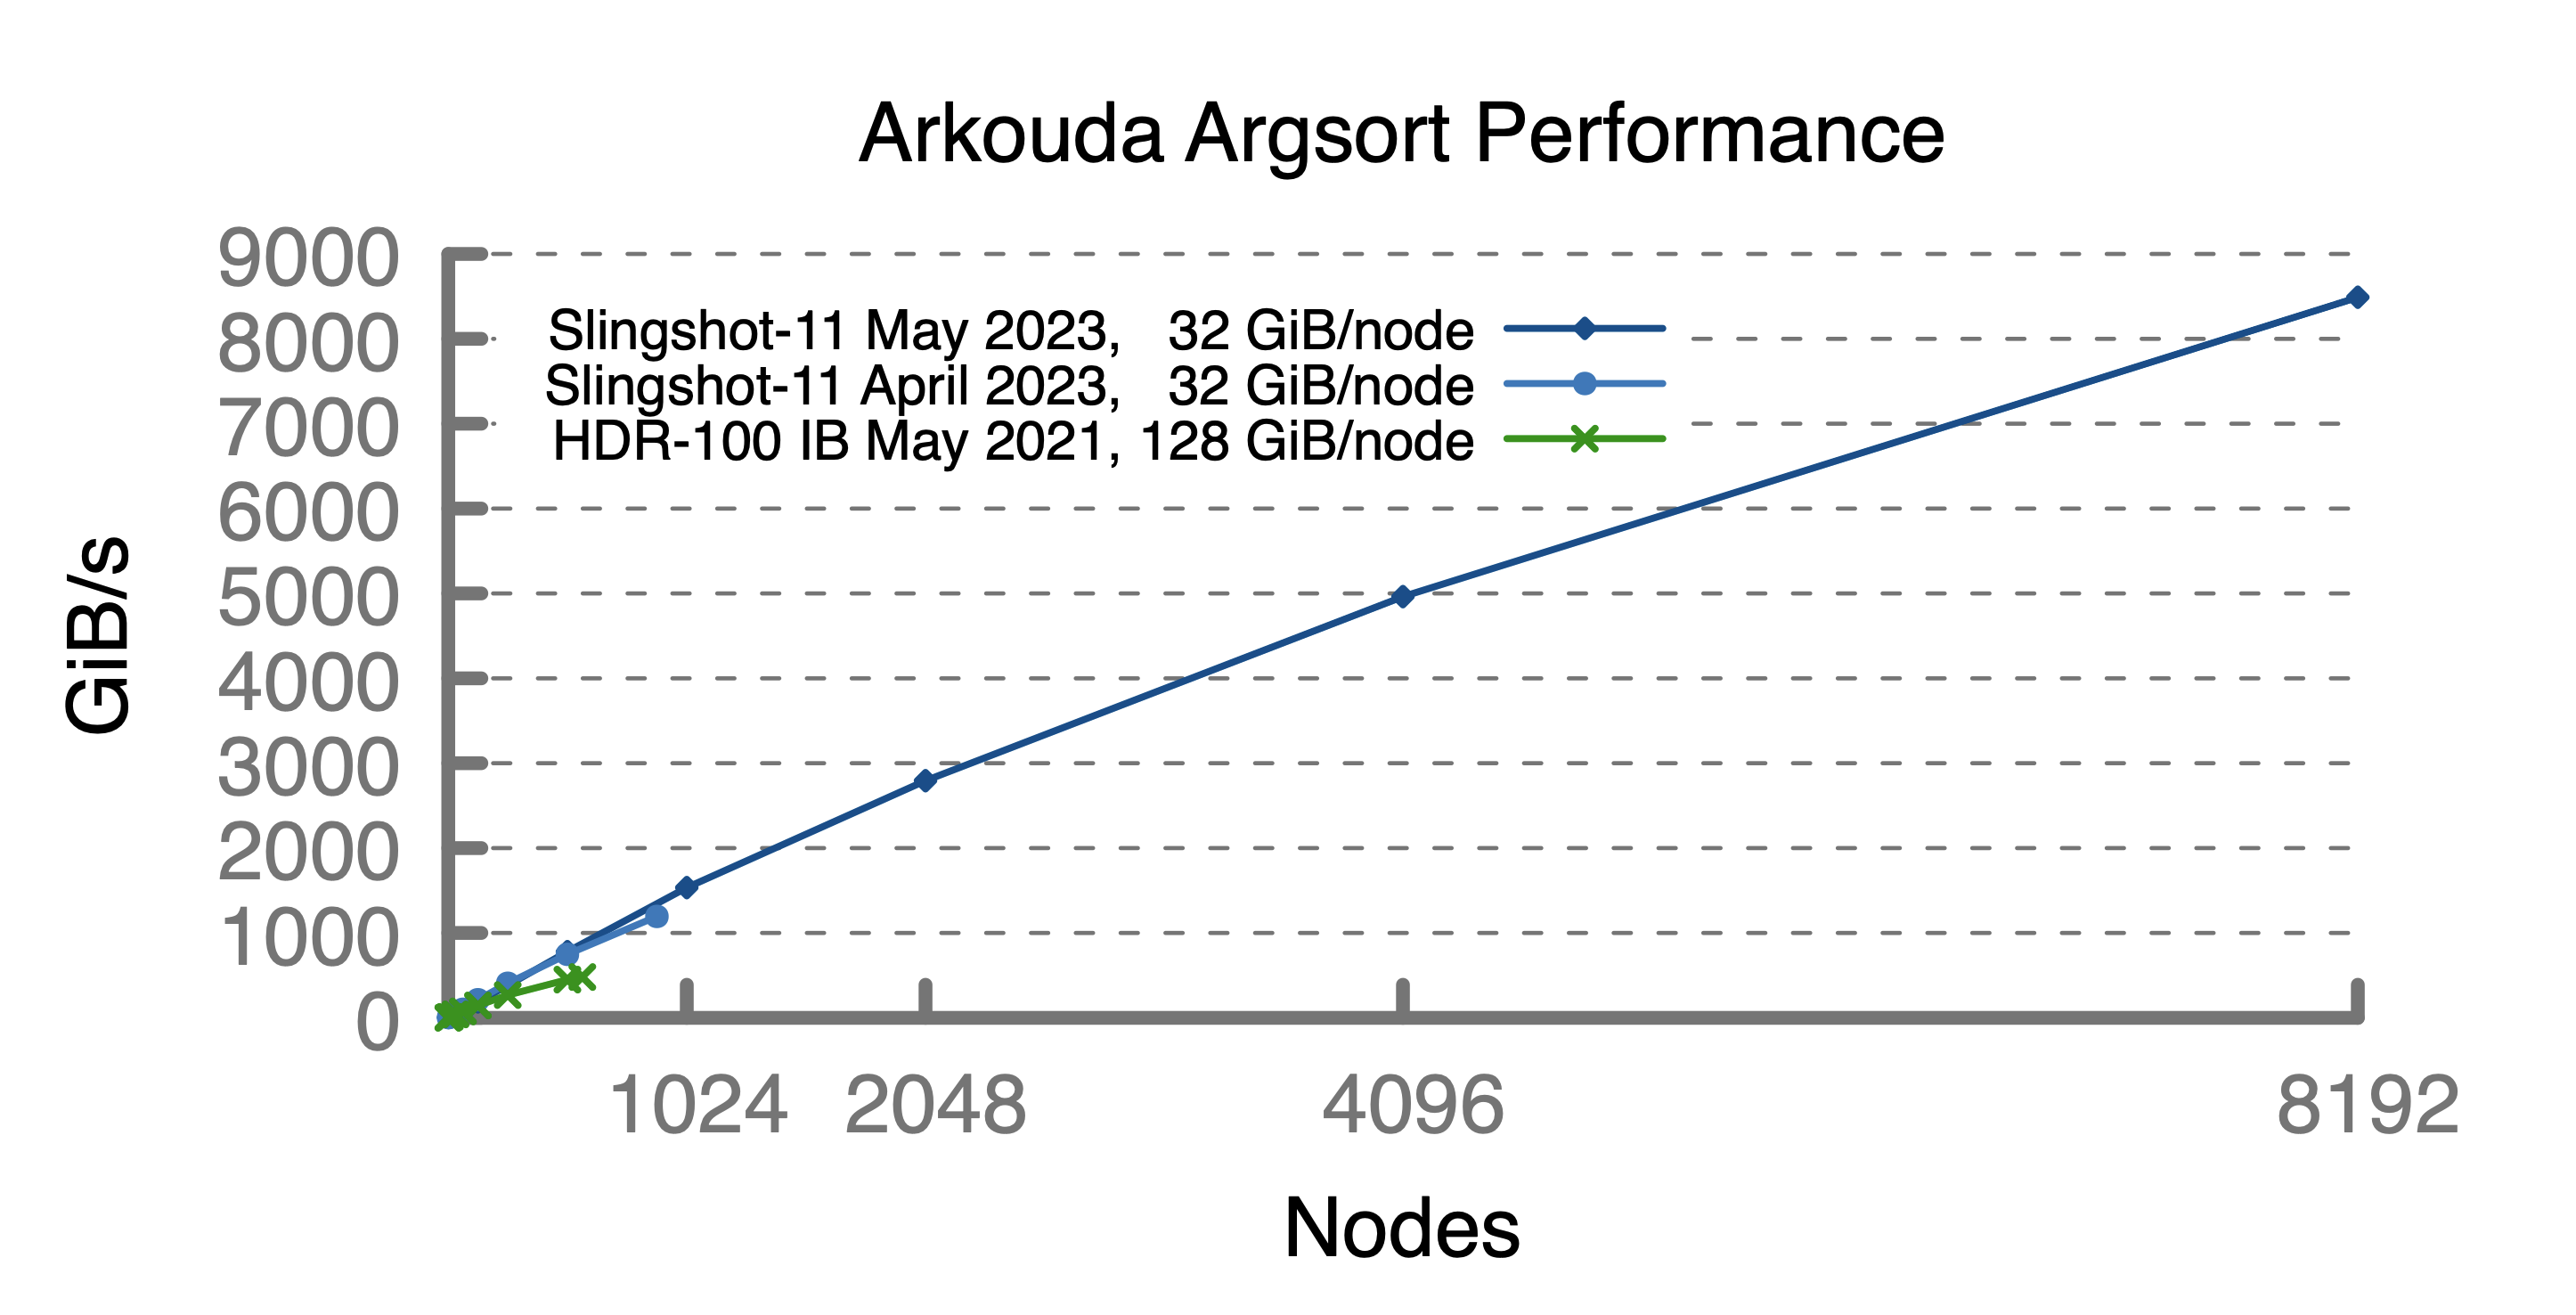

`ak.sort` sorts the given array.


In [18]:
a = ak.randint(0, 100, 10)
print(a)
ak.sort(a)

[86 39 48 25 30 92 51 98 2 73]


array([2 25 30 39 48 51 73 86 92 98])

`ak.argsort` returns the permutation of indices which sort the array.

In [19]:
a = ak.randint(0, 100, 10)
print(a)
perm = ak.argsort(a)  # Returns the indices that would sort a
print(perm)  # The sorted indices
a[perm]  # Sorts a using the sorted indices

[68 23 85 34 8 5 49 76 82 31]
[5 4 1 9 3 6 0 7 8 2]


array([5 8 23 31 34 49 68 76 82 85])

## Datframes
Arkouda supports dataframes through the `ak.DataFrame` class, which allows for operations similar to pandas. You can create an Arkouda dataframe, perform operations like merging and grouping, and even convert between Arkouda and pandas dataframes seamlessly.

importing pandas dataframe, and exporting to pandas


In [20]:
alien_id = [f"MSS-{str(i).zfill(3)}" for i in range(1, 11)]
species = ["Rodian", "Togruta", "Mon Calamari", "Hutt", "Twi'lek", "Ithorian", "Nautolan", "Quarren", "Devaronian", "Chagrian"]
tentacle_count = [0, 0, 6, 0, 2, 0, 14, 10, 0, 4]
liked_snack = [
        "Spicy Fried Womp Rat",       # Street food, Tatooine
        "Grilled Nuna Skewers",       # Game bird, seen on Naboo
        "Salted Karkan Tentacles",    # Seafood from Mon Cala
        "Deep-Fried Klatooine Patty", # Rich, greasy, Hutt-pleasing food
        "Bantha Butter Biscuits",     # Soft snack for dancers, entertainers
        "Thalassian Sausage Rolls",   # Ithorians love plant-based food
        "Coruscanti Kelp Dumplings",  # Aquatic, elegant
        "Sliced Meiloorun Tentacles", # Spicy fruit dish, Outer Rim
        "Charred Nerf Ribs",          # High-protein, hearty
        "Frozen Felucian Fungi Pie"   # Swampy, weird, exotic—very Chagrian
    ]

mood = [
        "Annoyed", "Grateful", "Sleepy", "Indifferent", "Playful",
        "Philosophical", "Recharged", "Skeptical", "Aggressive", "Mellow"
    ]

# Create a DataFrame directly from the lists in Arkouda, with the column names
# The data is sent to the Arkouda server in a single call, and distributed across all the locales
alien_df = ak.DataFrame({
    "ID": alien_id,
    "Species": species,
    "TentacleCount": tentacle_count,
    "LikedSnack": liked_snack,
    "Mood": mood
})
alien_df

,ID,Species,TentacleCount,LikedSnack,Mood
0,MSS-001,Rodian,0,Spicy Fried Womp Rat,Annoyed
1,MSS-002,Togruta,0,Grilled Nuna Skewers,Grateful
2,MSS-003,Mon Calamari,6,Salted Karkan Tentacles,Sleepy
3,MSS-004,Hutt,0,Deep-Fried Klatooine Patty,Indifferent
4,MSS-005,Twi'lek,2,Bantha Butter Biscuits,Playful
5,MSS-006,Ithorian,0,Thalassian Sausage Rolls,Philosophical
6,MSS-007,Nautolan,14,Coruscanti Kelp Dumplings,Recharged
7,MSS-008,Quarren,10,Sliced Meiloorun Tentacles,Skeptical
8,MSS-009,Devaronian,0,Charred Nerf Ribs,Aggressive
9,MSS-010,Chagrian,4,Frozen Felucian Fungi Pie,Mellow


In [21]:
# Select a single column
print(alien_df["Species"])

['Rodian', 'Togruta', 'Mon Calamari', 'Hutt', 'Twi'lek', 'Ithorian', 'Nautolan', 'Quarren', 'Devaronian', 'Chagrian']


#### Converting between Arkouda and Pandas DataFrames

To leverage Python's rich ecosystem of libraries, such as Matplotlib for plotting, we can convert an Arkouda DataFrame to a Pandas DataFrame using the `to_pandas()` method. This allows us to seamlessly integrate Arkouda's distributed data processing capabilities with Python's data visualization and analysis tools.

In [23]:
# Convert to pandas
alien_df.to_pandas()

,ID,Species,TentacleCount,LikedSnack,Mood
0,MSS-001,Rodian,0,Spicy Fried Womp Rat,Annoyed
1,MSS-002,Togruta,0,Grilled Nuna Skewers,Grateful
2,MSS-003,Mon Calamari,6,Salted Karkan Tentacles,Sleepy
3,MSS-004,Hutt,0,Deep-Fried Klatooine Patty,Indifferent
4,MSS-005,Twi'lek,2,Bantha Butter Biscuits,Playful
5,MSS-006,Ithorian,0,Thalassian Sausage Rolls,Philosophical
6,MSS-007,Nautolan,14,Coruscanti Kelp Dumplings,Recharged
7,MSS-008,Quarren,10,Sliced Meiloorun Tentacles,Skeptical
8,MSS-009,Devaronian,0,Charred Nerf Ribs,Aggressive
9,MSS-010,Chagrian,4,Frozen Felucian Fungi Pie,Mellow


Converting Pandas DataFrame to Arkouda is as simple as passing a pandas datafram to `ak.DataFrame`

In [25]:
import pandas as pd
# Create a DataFrame using pandas
# This is a local DataFrame, not distributed across the Arkouda server
species_meta_pd = pd.DataFrame({
    "Species": [
        "Rodian", "Togruta", "Mon Calamari", "Hutt", "Twi'lek",
        "Ithorian", "Nautolan", "Quarren", "Devaronian", "Chagrian"
    ],
    "Homeworld": [
        "Rodia", "Shili", "Mon Cala", "Nal Hutta", "Ryloth",
        "Ithor", "Glee Anselm", "Mon Cala", "Devaron", "Champala"
    ],
    "AvgSnackCaloryIntake": [420, 310, 600, 900, 250, 280, 340, 390, 520, 300]
})

# Convert the pandas DataFrame to an Arkouda DataFrame
species_meta = ak.DataFrame(species_meta_pd)
species_meta

,Species,Homeworld,AvgSnackCaloryIntake
0,Rodian,Rodia,420
1,Togruta,Shili,310
2,Mon Calamari,Mon Cala,600
3,Hutt,Nal Hutta,900
4,Twi'lek,Ryloth,250
5,Ithorian,Ithor,280
6,Nautolan,Glee Anselm,340
7,Quarren,Mon Cala,390
8,Devaronian,Devaron,520
9,Chagrian,Champala,300



#### Merging DataFrames in Arkouda

Arkouda provides the `ak.merge` function to combine two DataFrames based on a common column, similar to the `merge` function in pandas. This is useful for joining datasets with shared keys, such as combining metadata with observational data.

For example, we can merge `alien_df` with `species_meta` on the `Species` column to enrich the alien dataset with homeworld and average snack calorie information.


In [26]:
merged_df = ak.merge(alien_df, species_meta, on="Species")
merged_df

,Species,ID,TentacleCount,LikedSnack,Mood,Homeworld,AvgSnackCaloryIntake
0,Chagrian,MSS-010,4,Frozen Felucian Fungi Pie,Mellow,Champala,300
1,Devaronian,MSS-009,0,Charred Nerf Ribs,Aggressive,Devaron,520
2,Hutt,MSS-004,0,Deep-Fried Klatooine Patty,Indifferent,Nal Hutta,900
3,Ithorian,MSS-006,0,Thalassian Sausage Rolls,Philosophical,Ithor,280
4,Mon Calamari,MSS-003,6,Salted Karkan Tentacles,Sleepy,Mon Cala,600
5,Nautolan,MSS-007,14,Coruscanti Kelp Dumplings,Recharged,Glee Anselm,340
6,Quarren,MSS-008,10,Sliced Meiloorun Tentacles,Skeptical,Mon Cala,390
7,Rodian,MSS-001,0,Spicy Fried Womp Rat,Annoyed,Rodia,420
8,Togruta,MSS-002,0,Grilled Nuna Skewers,Grateful,Shili,310
9,Twi'lek,MSS-005,2,Bantha Butter Biscuits,Playful,Ryloth,250


### GroupBy Operations in Arkouda

Arkouda supports `groupby` operations, allowing you to perform aggregations like `count`, `mean`, and `sum` on grouped data. This is particularly useful for summarizing and analyzing large datasets distributed across multiple nodes.

`groupby`s in Arkouda are powered by Arkouda's massive scale sorting capabilites and is therefore highly performant.

For example, you can group the `alien_df` DataFrame by the `Homeworld` column and compute the count, mean, or sum of the `TentacleCount` column.

In [27]:
#Group by Homeworld and get mean TentacleCount
merged_df.groupby("Homeworld").mean("TentacleCount")

,TentacleCount
Homeworld,
Ithor,0.0
Rodia,0.0
Shili,0.0
Devaron,0.0
Ryloth,2.0
Champala,4.0
Mon Cala,8.0
Nal Hutta,0.0
Glee Anselm,14.0


In [28]:
# Group by Mood and sum total snack calories eaten by mood
merged_df.groupby("Mood").sum("AvgSnackCaloryIntake")

,AvgSnackCaloryIntake
Mood,
Annoyed,420
Mellow,300
Playful,250
Sleepy,600
Grateful,310
Recharged,340
Skeptical,390
Aggressive,520
Indifferent,900


In [29]:
# We can answer questions about our data
# Like who has the most tentacles per calorie?
merged_df["TentaclesPerCalorie"] = merged_df["TentacleCount"] / merged_df["AvgSnackCaloryIntake"]
merged_df

,Species,ID,TentacleCount,LikedSnack,Mood,Homeworld,AvgSnackCaloryIntake,TentaclesPerCalorie
0,Chagrian,MSS-010,4,Frozen Felucian Fungi Pie,Mellow,Champala,300,0.013333
1,Devaronian,MSS-009,0,Charred Nerf Ribs,Aggressive,Devaron,520,0.000000
2,Hutt,MSS-004,0,Deep-Fried Klatooine Patty,Indifferent,Nal Hutta,900,0.000000
3,Ithorian,MSS-006,0,Thalassian Sausage Rolls,Philosophical,Ithor,280,0.000000
4,Mon Calamari,MSS-003,6,Salted Karkan Tentacles,Sleepy,Mon Cala,600,0.010000
5,Nautolan,MSS-007,14,Coruscanti Kelp Dumplings,Recharged,Glee Anselm,340,0.041176
6,Quarren,MSS-008,10,Sliced Meiloorun Tentacles,Skeptical,Mon Cala,390,0.025641
7,Rodian,MSS-001,0,Spicy Fried Womp Rat,Annoyed,Rodia,420,0.000000
8,Togruta,MSS-002,0,Grilled Nuna Skewers,Grateful,Shili,310,0.000000
9,Twi'lek,MSS-005,2,Bantha Butter Biscuits,Playful,Ryloth,250,0.008000


## Plotting

We can transfer data from Arkouda to the client using the `to_ndarray` method, which converts Arkouda arrays to NumPy arrays. This allows us to leverage Python's rich ecosystem of plotting libraries, such as Matplotlib, to visualize our data. For example, we can plot the "Tentacles per Calorie" metric for each species using a bar chart.

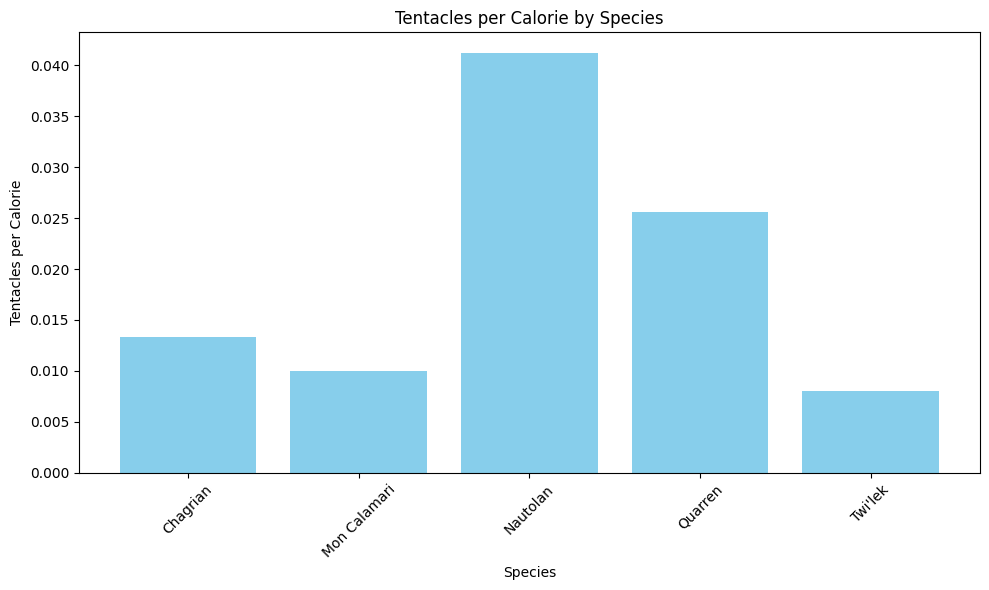

In [32]:
import matplotlib.pyplot as plt
import numpy as np
tentacles_per_calorie = merged_df["TentaclesPerCalorie"]
species = merged_df["Species"]

# Filter values where tentacles per calorie is greater than 0
mask = tentacles_per_calorie > 0
filtered_tentacles_per_calorie = tentacles_per_calorie[mask].to_ndarray()
filtered_species = species[mask].to_ndarray()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(filtered_species, filtered_tentacles_per_calorie, color='skyblue')

plt.xlabel("Species")
plt.ylabel("Tentacles per Calorie")
plt.title("Tentacles per Calorie by Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Squirrel demo

The Squirrel Census demo uses a quirky but real-world dataset from the 2018 NYC Squirrel Census, where volunteers recorded over 3,000 squirrel sightings in Central Park. Each record includes details like fur color, behavior (e.g., climbing, foraging, chasing), vocalizations (like "quaas" or "kuks"), and interactions with humans.

We will try to do some Exploratory Data Analysis (EDA) on this dataset.

### Table of Contents
1. Read file
2. Overview of dataset
3. Fur color count
4. Activities by time of day, running, chasing, climbing eating foraging in AM vs PM and by fur color
5. Which squirrel is most friendly. Approaching +2, indifferent +1, runs from -2
6. Find a needle in a haystack: grey squirrel quaas sound and eating or climbing and twitching the tail
7. Graph some of the above,
8. Graph all sightings on grid.

In [ ]:
import pandas as pd

pd_df = pd.read_csv("/home/users/khandeka/arkouda/examples/2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250421.csv")

# 2. Overview of dataset
print("Columns:", pd_df.columns.tolist())
print("Shape:", pd_df.shape)
print("\nHead:\n")
pd_df.to_parquet("/home/users/khandeka/arkouda/examples/squirrel_data.parquet")
pd_df.head(5)


####  Read file

Today, Arkouda supports a couple of staple file formats:
- Parquet : Data science columnar file format
- HDF5    : HPC file format designed for large data sets
- CSV     : Standard file format for small data sets

The squirrel census data is in the parquet format, a file format readable by Arkouda.

When possible, it is recommended to use Parquet or HDF5 for I/O in Arkouda, since the performance with those formats are much better than CSV.

When writing files in Arkouda, one file per locale is written to disk. For example, if you are writing a large dataset that is distributed across a 16-locale server, 16 files will be written, 1 per locale, each named with the pattern `<filename-prefix>_LOCALE####`.

There are currently efforts to add support for additional file formats, such as Zarr and NetCDF, as well as efforts to improve the performance of existing formats.

In [34]:
# 1. Read file
data_path = "/home/users/khandeka/arkouda/examples/squirrel_data.parquet"
# Read the parquet file
data_dict = ak.read_parquet(data_path)
df = ak.DataFrame(data_dict)

# 2. Overview of dataset
print("Columns:", df.columns.to_list())
print("Shape:", df.shape)
print("\nHead:\n")
df

Columns: ['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date', 'Hectare Squirrel Number', 'Age', 'Primary Fur Color', 'Highlight Fur Color', 'Combination of Primary and Highlight Color', 'Color notes', 'Location', 'Above Ground Sighter Measurement', 'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from', 'Other Interactions', 'Lat/Long']
Shape: (3023, 31)

Head:



,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,,,,...,False,False,False,False,False,False,False,False,,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,,,,...,False,False,False,False,False,False,False,False,,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,,Gray,,...,False,False,False,False,False,False,False,False,,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,,...,False,False,False,False,False,False,False,True,,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,,POINT (-73.9702676472613 40.7762126854894)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,,...,False,False,False,False,False,False,False,True,,POINT (-73.9639431360458 40.7908677445466)
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,White,...,False,False,False,False,False,False,True,False,,POINT (-73.9704015859639 40.7825600069973)
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Black, Cinnamon, White",...,False,False,False,False,False,False,True,False,,POINT (-73.9665871993517 40.7836775064883)
3021,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,,Gray,"Cinnamon, White",...,False,False,False,False,False,False,True,False,,POINT (-73.9639941227864 40.7899152327912)


#### Fur color count

This can be done with a very basic groupby, and select a token column so we don't get all the columns in the output.

In [ ]:
# groupby and count
result = df.groupby("Primary Fur Color").count("X")
result

,X
Primary Fur Color,
,55
Gray,2473
Black,103
Cinnamon,392


#### Activities by time of day, running, chasing, climbing eating foraging in AM vs PM and by fur color

This is an interesting question one could ask about these squirrels: What do they do during the day vs during the night?
We can group by `Shift`, and by `Primary Fur Color` and then see what these guys are doing during the day vs night.

We have to cast bool columns to int to make sure `ak.groupby` does not remove them.

In [42]:
bool_cols = [col for col in df.columns if df[col].dtype == ak.bool_]

for col in bool_cols:
    df[col] = df[col].astype(ak.int64)

# 4. Activities by time of day and fur color
activity_cols = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']

# Group by Shift and Fur Color, then sum activity columns
activity_summary = (
    df.groupby(['Shift', 'Primary Fur Color'])
    .sum(activity_cols)
)

print("\nActivity summary (AM/PM × Fur Color):")
activity_summary


Activity summary (AM/PM × Fur Color):


,Shift,Primary Fur Color,Running,Chasing,Climbing,Eating,Foraging
0,AM,,3,2,12,2,5
1,AM,Gray,261,115,268,235,493
2,AM,Black,12,4,12,8,22
3,AM,Cinnamon,51,10,48,51,81
4,PM,,1,2,6,4,1
5,PM,Gray,336,123,265,384,690
6,PM,Black,14,3,13,16,21
7,PM,Cinnamon,52,20,34,60,122


#### Which squirrel is most friendly?

We calculate a friendliness score for each squirrel based on their behavior:
- Approaches humans: +2 points
- Indifferent to humans: +1 point
- Runs from humans: -2 points

The top 5 friendliest squirrels are displayed below.

In [43]:

# Custom score: Approaches +2, Indifferent +1, Runs from -2
df["friendliness_score"] = (
    df["Approaches"].astype(int) * 2 +
    df["Indifferent"].astype(int) * 1 -
    df["Runs from"].astype(int) * 2
)

friendly_top = df[["Unique Squirrel ID", "friendliness_score"]].sort_values(
    by="friendliness_score", ascending=False
).head(5)

print("\nTop 5 friendliest squirrels:")
friendly_top



Top 5 friendliest squirrels:


,Unique Squirrel ID,friendliness_score
475,42D-PM-1013-01,3
642,13C-PM-1019-05,3
830,36D-PM-1007-02,3
841,17I-AM-1014-04,3
997,33D-AM-1017-03,3


#### Find a needle in a haystack, answering specific questions in Arkouda

I want to look for a grey squirrel that was making the quaas sound and eating or climbing and twitching the tail at the same time.


In [78]:

quirky_filter = (
    (df["Primary Fur Color"] == "Gray") &
    (df["Quaas"] == True) &
    ((df["Eating"] == True) | ((df["Climbing"] == True))) &
    (df["Tail twitches"] == True)
)

quirky_squirrels = df[quirky_filter]
print("\nQuirky squirrels (gray + quaas + (eating or climbing) & twitching):")
quirky_squirrels[["Unique Squirrel ID", "Primary Fur Color", "Quaas", "Eating", "Climbing", "Tail twitches"]]



Quirky squirrels (gray + quaas + (eating or climbing) & twitching):


,Unique Squirrel ID,Primary Fur Color,Quaas,Eating,Climbing,Tail twitches
1106,23F-PM-1013-02,Gray,1,1,0,1
1969,36C-PM-1013-02,Gray,1,1,0,1
2699,35C-PM-1013-01,Gray,1,0,1,1


#### Graphing the information we've got

Let's plot some of the data that we've collected here

1. Squirrel Fur Color Distribution
2. What are squirrels doing during the day vs night?
3. How friendly are Central park squirrels?
4. Where do the quirky quirrels live?

,X
Primary Fur Color,
,55
Gray,2473
Black,103
Cinnamon,392


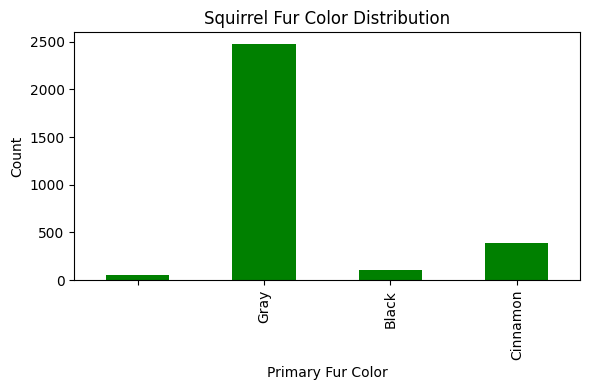

In [53]:
gb = df.groupby("Primary Fur Color")
counts = gb.count("X")
display(counts)
counts_pd = counts.to_pandas(retain_index=True)

# Fur color count
plt.figure(figsize=(6, 4))
counts_pd["X"].plot(kind="bar", color="green")
plt.title("Squirrel Fur Color Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


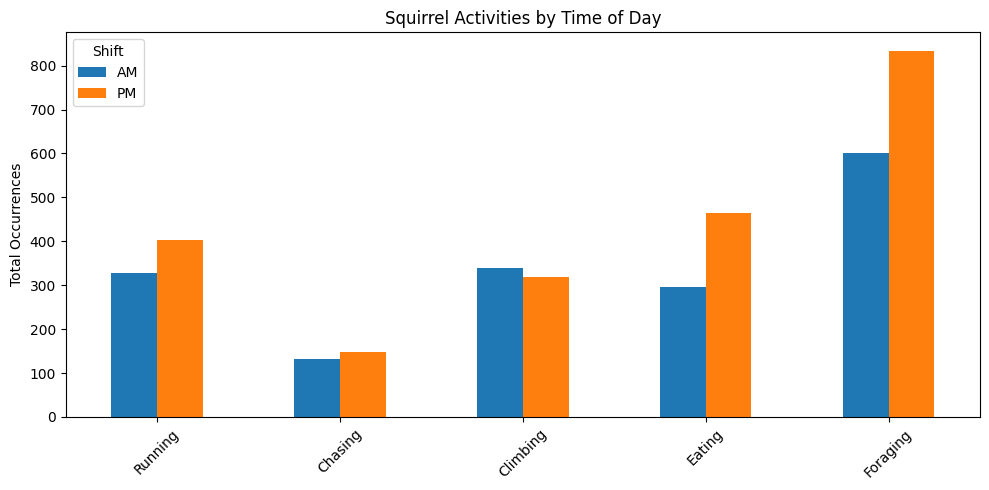

In [54]:
# Activity by Shift
shift_activity = df.groupby("Shift").sum(activity_cols)
shift_activity = shift_activity.to_pandas(retain_index=True)
shift_activity.T.plot(kind="bar", figsize=(10, 5))
plt.title("Squirrel Activities by Time of Day")
plt.ylabel("Total Occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What can explain the above graph?

Does this necessarily mean that the squirrels are more active during the evening?

What could be another cause for this?

##### Histogramming in Arkouda

We can use `ak.histogram` to bin our data for histogramming and then send it to the client for plotting.

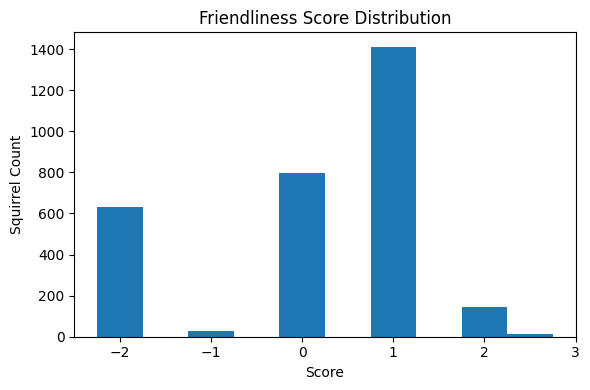

In [65]:

# Friendliness distribution
h, bins = ak.histogram(df["friendliness_score"], bins=10)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1].to_ndarray(), h.to_ndarray(), width=bins[1]-bins[0])
plt.title("Friendliness Score Distribution")
plt.xlabel("Score")
plt.ylabel("Squirrel Count")
plt.tight_layout()
plt.show()


#### Graphing sightings of our quirky squirrels on a map

We can use the same filters from earlier which got us those 6 special squirrels, and plot where in central park they were seen.

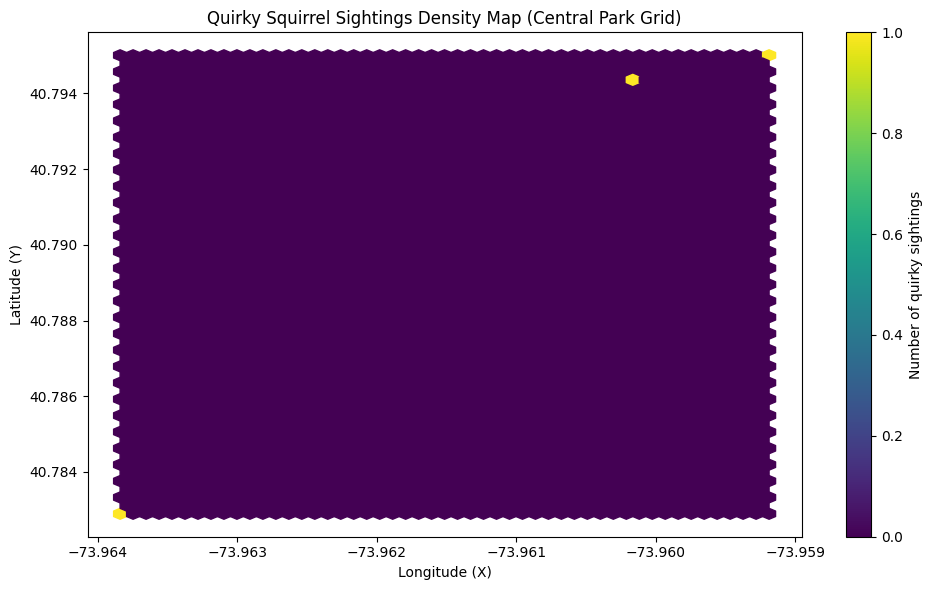

In [ ]:
# Filter the quirky squirrels
quirky_squirrels_clean = quirky_squirrels.dropna().to_pandas()

# Plot the quirky squirrels
plt.figure(figsize=(10, 6))
plt.hexbin(quirky_squirrels_clean["X"], quirky_squirrels_clean["Y"], gridsize=50, cmap='viridis')
plt.colorbar(label='Number of quirky sightings')
plt.title("Quirky Squirrel Sightings Density Map (Central Park Grid)")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.tight_layout()
plt.show()

This graph is so interesting! These squirrels are at opposing ends of the map!
What can the data scientist glean from this graph?
What does the tail twitching mean? Curiosity! Perhaps the city itself is making the squirrel curious?
Or maybe there are trees in those areas of central park, or any other insight that the data scientist must gleam from this.

Arkouda is veru useful for cases like this where we are trying to look for a needle in a haystack.

### Disconnect From or Shutdown Server

In [ ]:
# ak.disconnect()

# ak.shutdown()